# SD212: Graph mining

## Project

### Title: Clustering food items by nutrient similarity

### Students: Rémy Tang, Eliott Tourtois

The goal of this project is to learn how to extract useful information from graph data. 

Your task is the following:
* build your own graph from real data
* specify the problem(s) you would like to solve
* provide a solution
* visualize the results

## Instructions

You can work in **teams of 2 or 3**.

Fill the following variable with the names of all students of this project separated by _:

In [1]:
name = 'tang_tourtois'

You **must** use this name for the pickle file of your dataset and provide a link to this file:

In [2]:
# url to your dataset, to be modified
# Please download the file manually and put it in the same directory as this notebook
url = 'https://drive.google.com/file/d/14AeVRsT5FPtfrefzVEcYg4k572DxN9dK/view?usp=sharing'

Check the notebook ``my_dataset`` to generate a pickle file in appropriate format (``Bunch`` object).

You must use the following name for your notebook:

In [3]:
# name of your notebook
name + '.ipynb'

'tang_tourtois.ipynb'

## Data

#### Import the data from the bunch object

In [4]:
import pickle

In [5]:
# you need to download data first (see the above url)
with open(name, 'br') as f:
    dataset = pickle.load(f)

In [6]:
adjacency = dataset.adjacency

#### Describe your data and how it has been collected (do not include the code used to extract data).

The dataset was collected from Kaggle. More specifically, the Kaggle dataset contains food nutrient availability for 7413 foods, pertaining to 1183 unique categories (e.g. cheese, egg, vegetable oil, etc.).

The Kaggle dataset itself was extracted from the U.S. Department of Agriculture, and contains the "most common" foods from the complete dataset. However, when exploring the data, we discovered that there were many uncommon items (for example Alaskan whale meat, which belongs in the `WHALE` category). We still chose to keep all foods to avoid doing unecessary work.

To build the adjacency matrix from this data, we first decided to select a few key nutrients to build a 'nutrient vector'. This allowed us to easily compare food in the space of the selected nutrients.

We also normalized all nutrients to make more relevant comparisons between nutrient quantities, as we did not search for their nominal values.

Then we chose to make links between two instances of food if the distance between their nutrient vector was smaller than a certain hand-tuned threshold.

A lot of iterations were necessary in order to tune the number of selected nutrients, as well as the distance threshold to get a satisfying result. This process was therefore very time-consuming as we did not find any other way to create relevant edges.

The selected nutrients are Vit. B12, Calcium, Iron, Zinc, Fiber, Vit. C, Beta-Caroteme. The threshold was tuned to that the number of edges be around $10^5$ to $10^6$, so that we respect the constraints imposed by the project rules while still keeping a good amount of edges.

The bunch object itself contains :

- `dataset.adjacency` : the adjacency matrix (as defined above) 
- `dataset.node_feature` : the selected nutrients for the food
- `dataset.category` : the category of the food
- `dataset.description` : the specific name of the food

## Problem

#### Describe the problem you want to solve (be concise).

The goal of this project is to find how to compensate the most common nutrient deficiencies in vegetarian diets.

According to this scientific article [Nutrition concerns and health effects of vegetarian diets (Craig WJ 2010)](https://pubmed.ncbi.nlm.nih.gov/21139125/), the most common nutrient deficiencies in vegetarian diets involve "vitamin B12, vitamin D, ω-3 fatty acids, calcium, iron, and zinc". 

On the contrary, such a diet provides plenty of fiber, vitamin C, and β-carotene (a precusor of vitamin A found in fruits and vegetables). Our dataset does not provide ω-3 fatty acids and calcium content of the food, so we will only study the other nutrients. Side note : vitamin D increases calcium absorption in the body, so it is not completely unrelated to calcium availability.

More specifically, we want to build food groups from nutritional information of common foods, based on their nutrient profile (for a few select nutrients). All the foods in a group should have a similar nutrient availability.
This way, we will try to identify fruits and vegetables (by their high fiber, vitamin C, and β-carotene content) that have either high vitamin B12, calcium, iron, zinc, or a combination of them.

## Solution

Describe your solution, including the code and a visualization of the results.

To solve our problem, we created clusters based on nutrient profiles from all the food in the dataset and the edges we have built from the raw data. Using different clustering methods, we can compare how they fare and examine how relevant their clusters are.

The clustering algorithms used in this project are :
- k-means
- Louvain

One caveat here is that our food is already labeled with categories. Therefore creating clusters that replicate data categories would be redundant. Instead, because we use nutrient profiles to make edges in our graph, we can uncover new links between food belonging to different categories.

### Building the clusters
#### Imports

In [7]:
!pip install svglib
!pip install reportlab
!pip install --ignore-installed Pillow==9.0.0

  Using cached Pillow-9.0.0-cp38-cp38-win_amd64.whl (3.2 MB)


In [8]:
#Classic imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns

#Sknetwork imports
from sknetwork.clustering import Louvain, modularity, KMeans
from sknetwork.visualization import svg_graph
from sknetwork.embedding import Spectral, SVD
from sknetwork.linalg import normalize

#Import to fix an error on Eliott's computer
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#To convert svg's into png's, (utility librairies)
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM


#### Prepare Embeddings

In [9]:
svd = SVD(2)
embeddingsvd = svd.fit_transform(adjacency)
spectral = Spectral(2)
embeddingspectral = spectral.fit_transform(adjacency)

#### Louvain

In [10]:
louvain = Louvain(verbose=True,n_aggregations= 4,tol_optimization = 0.0001, tol_aggregation = 0.0001,random_state=42)
louvainLabels = louvain.fit_transform(dataset.adjacency)
print('Modularité =', modularity(adjacency, louvainLabels))

Starting with 7413 nodes.
Aggregation 1 completed with 2014 clusters and  0.6721267700195312 increment.
Aggregation 2 completed with 1827 clusters and  0.009744934737682343 increment.
Aggregation 3 completed with 1808 clusters and  0.0002474522916600108 increment.
Aggregation 4 completed with 1808 clusters and  9.047198545886204e-07 increment.
Modularité = 0.6963700059048976


In [11]:
#For future aggregation
louvain_adjacency_aggregate = louvain.aggregate_
louvainLabels_unique, louvainCounts = np.unique(louvainLabels, return_counts=True)
average = normalize(louvain.membership_.T)
embeddingLouvainAgg = average.dot(embeddingspectral)

##### Visualization

In [12]:
LouvainSpectralimg = svg_graph(adjacency,position =embeddingspectral, labels=louvainLabels, node_size=5, display_edges=False,edge_width=3 ,width = 900, height = 800)
LouvainSvdimg = svg_graph(adjacency,position =embeddingsvd, labels=louvainLabels, node_size=5, display_edges=False,edge_width=3 ,width = 900, height = 800)
f1 = open("LouvainSpectral.svg","w")
f1.write(LouvainSpectralimg)
f1.close()
drawing = svg2rlg("LouvainSpectral.svg")
renderPM.drawToFile(drawing, "LouvainSpectral.png", fmt="PNG")
f2 = open("LouvainSvd.svg","w")
f2.write(LouvainSvdimg)
f2.close()
drawing = svg2rlg("LouvainSvd.svg")
renderPM.drawToFile(drawing, "LouvainSvd.png", fmt="PNG")

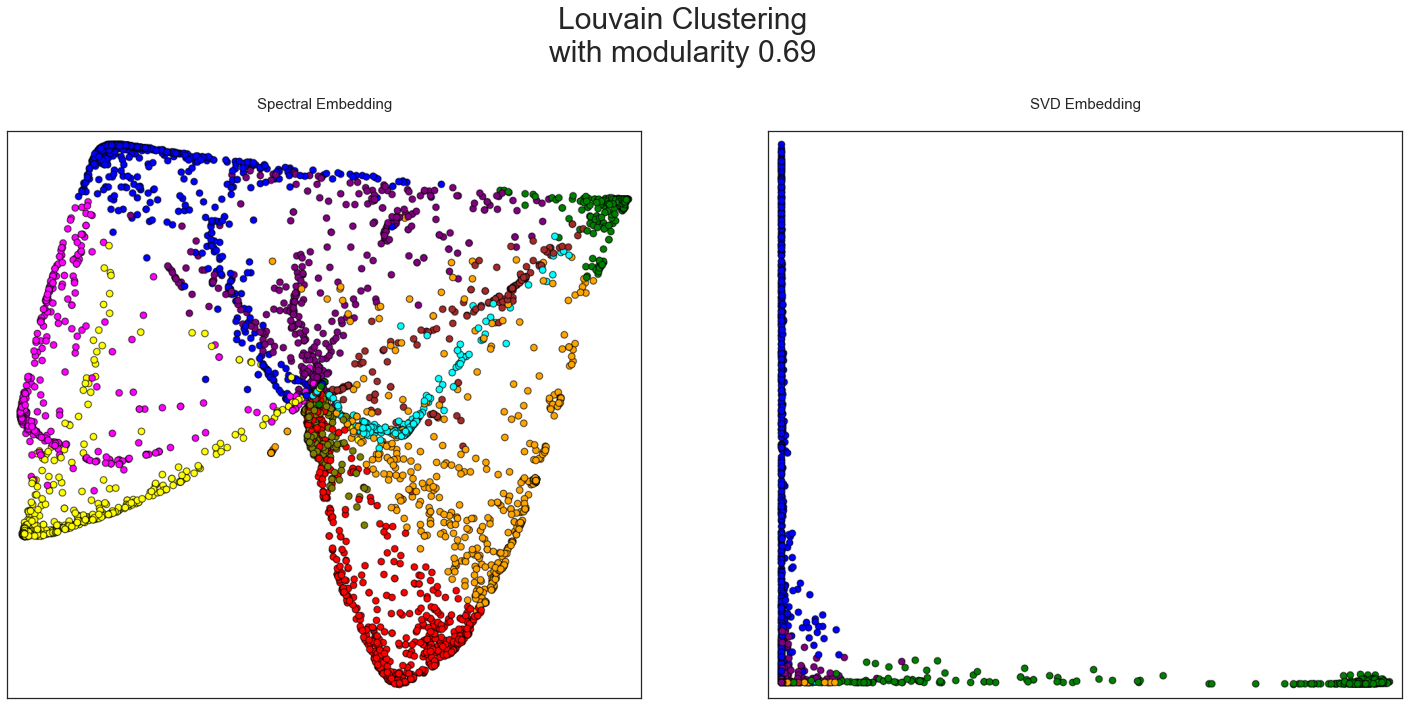

In [13]:
sns.set_theme(style="white")
f,axs=plt.subplots(1,2,figsize=(25,15))
axs[0].imshow(img.imread("LouvainSpectral.png"))
axs[1].imshow(img.imread("LouvainSvd.png"))
axs[0].set(yticklabels=[],xticklabels=[])
axs[1].set(yticklabels=[],xticklabels=[])
axs[0].set_title("Spectral Embedding\n", fontsize =15)
axs[1].set_title("SVD Embedding\n", fontsize =15)
plt.suptitle("Louvain Clustering\nwith modularity "+ str(modularity(dataset.adjacency, louvainLabels))[0:4],y=0.88,fontsize=30)
plt.show()

#### Kmeans

In [14]:
np.random.seed(42)
kmeans = KMeans(n_clusters=20, embedding_method=Spectral(3))
kmeansLabels = kmeans.fit_transform(dataset.adjacency)
print('Modularité =', modularity(dataset.adjacency, kmeansLabels))

Modularité = 0.5724982208773102


In [15]:
#For Future aggregation
kmeans_adjacency_aggregate = kmeans.aggregate_
kmeansLabels_unique, kmeansCounts = np.unique(kmeansLabels, return_counts=True)
average = normalize(kmeans.membership_.T)
embeddingKmeansAgg = average.dot(embeddingspectral)

##### Visualization

In [16]:
KmeansSpectralimg = svg_graph(adjacency,position =embeddingspectral, labels=kmeansLabels, node_size=5, display_edges=False,edge_width=3 ,width = 900, height = 800)
KmeansSvdimg = svg_graph(adjacency,position =embeddingsvd, labels=kmeansLabels, node_size=5, display_edges=False,edge_width=3 ,width = 900, height = 800)
f1 = open("KmeansSpectral.svg","w")
f1.write(KmeansSpectralimg)
f1.close()
drawing = svg2rlg("KmeansSpectral.svg")
renderPM.drawToFile(drawing, "KmeansSpectral.png", fmt="PNG")
f2 = open("KmeansSvd.svg","w")
f2.write(KmeansSvdimg)
f2.close()
drawing = svg2rlg("KmeansSvd.svg")
renderPM.drawToFile(drawing, "KmeansSvd.png", fmt="PNG")

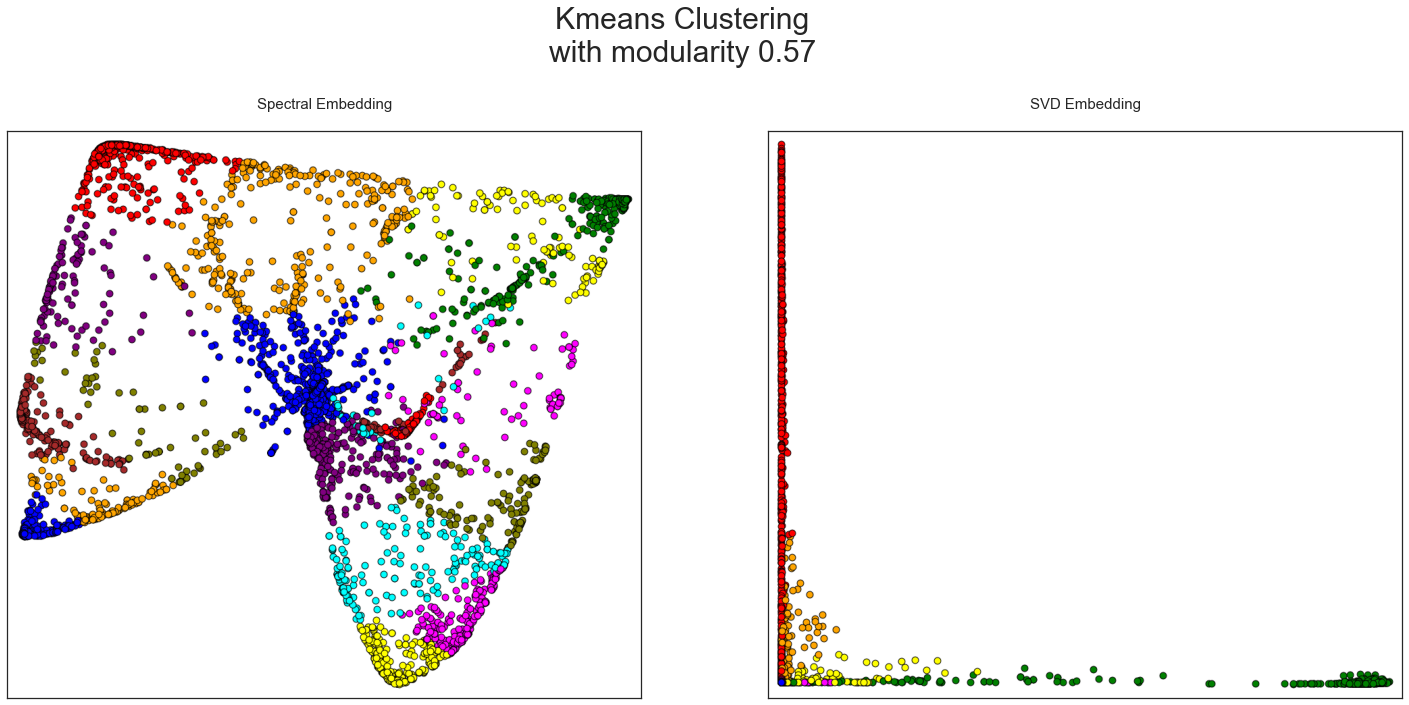

In [17]:
sns.set_theme(style="white")
f,axs=plt.subplots(1,2,figsize=(25,15))
axs[0].imshow(img.imread("KmeansSpectral.png"))
axs[1].imshow(img.imread("KmeansSvd.png"))
axs[0].set(yticklabels=[],xticklabels=[])
axs[1].set(yticklabels=[],xticklabels=[])
axs[0].set_title("Spectral Embedding\n", fontsize =15)
axs[1].set_title("SVD Embedding\n", fontsize =15)
plt.suptitle("Kmeans Clustering\nwith modularity "+ str(modularity(dataset.adjacency, kmeansLabels))[0:4],y=0.88,fontsize=30)
plt.show()

#### Aggregation

In [18]:
LouvainAggimg = svg_graph(louvain_adjacency_aggregate,position =embeddingLouvainAgg, labels=louvainLabels_unique, node_size_min=5, node_size_max = 50, display_node_weight=True, display_edges=True,node_weights=louvainCounts,edge_width=3 ,width = 900, height = 800)
KmeansAggimg = svg_graph(kmeans_adjacency_aggregate,position =embeddingKmeansAgg, labels=kmeansLabels_unique, node_size_min=5, node_size_max = 50, display_node_weight=True, display_edges=True,node_weights=kmeansCounts,edge_width=3 ,width = 900, height = 800)
f1 = open("KmeansAgg.svg","w")
f1.write(KmeansAggimg)
f1.close()
drawing = svg2rlg("KmeansAgg.svg")
renderPM.drawToFile(drawing, "KmeansAgg.png", fmt="PNG")
f2 = open("LouvainAgg.svg","w")
f2.write(LouvainAggimg)
f2.close()
drawing = svg2rlg("LouvainAgg.svg")
renderPM.drawToFile(drawing, "LouvainAgg.png", fmt="PNG")

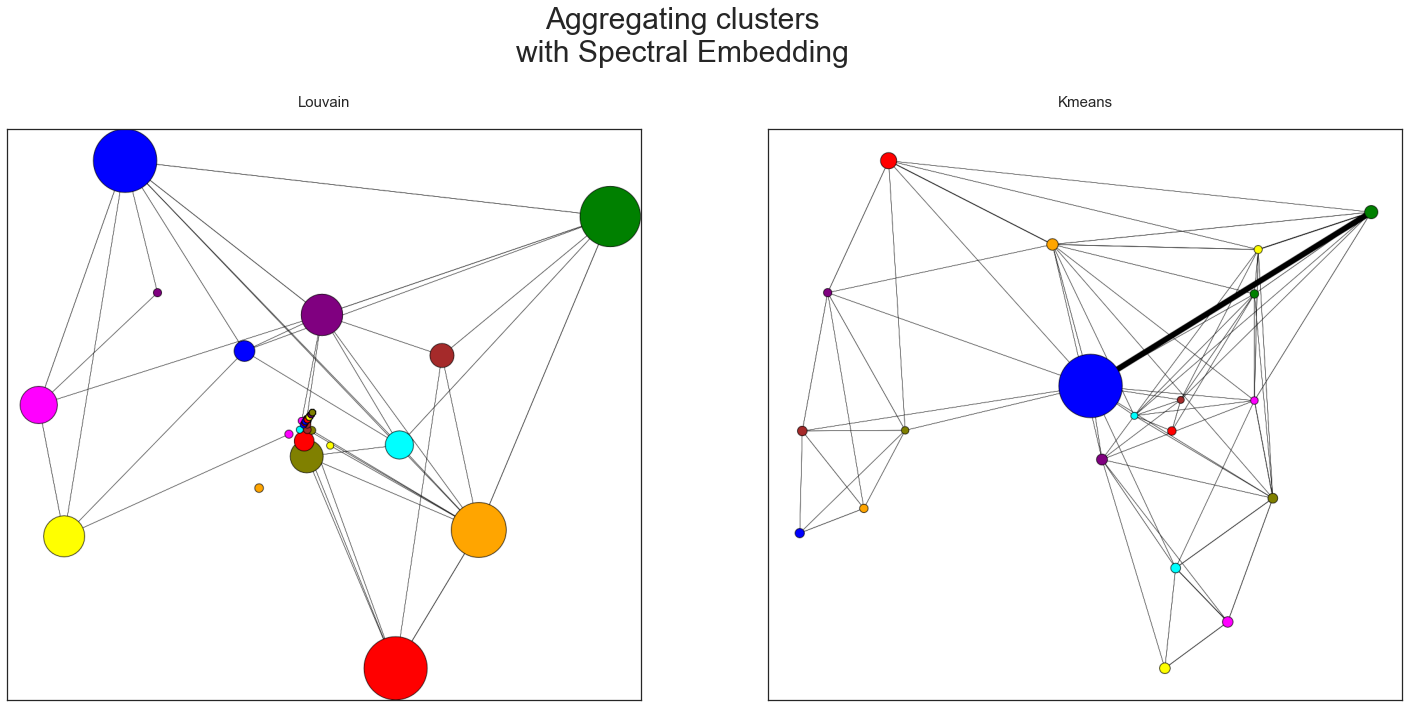

In [19]:
sns.set_theme(style="white")
f,axs=plt.subplots(1,2,figsize=(25,15))
axs[0].imshow(img.imread("LouvainAgg.png"))
axs[1].imshow(img.imread("KmeansAgg.png"))
axs[0].set(yticklabels=[],xticklabels=[])
axs[1].set(yticklabels=[],xticklabels=[])
axs[0].set_title("Louvain\n", fontsize =15)
axs[1].set_title("Kmeans\n", fontsize =15)
plt.suptitle("Aggregating clusters\nwith Spectral Embedding",y=0.88,fontsize=30)
plt.show()

We can see that Louvain has a better distribution of clusters than kmeans. Kmeans instead creates a big center cluster. However, Louvain makes a lot a tiny clusters. 

#### Comparison Between Louvain and Kmeans
We use 20 clusters for Kmeans hence we only look at the first 20 clusters of Louvain.
This number was found empirically.

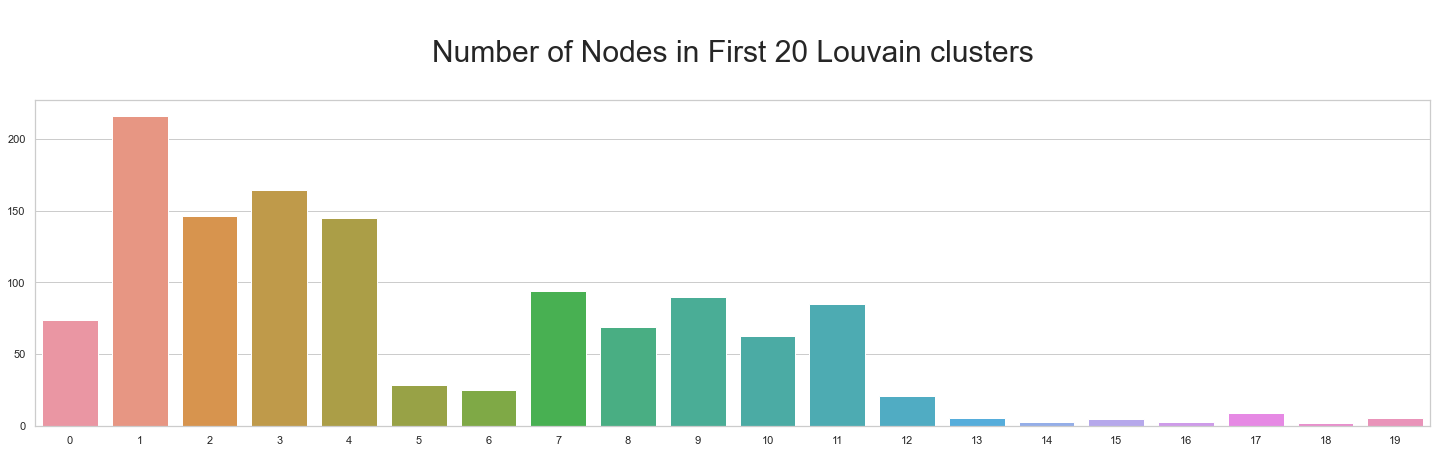

In [20]:
indexes = []
for i in range(20):
    indexes.append(np.where(louvainLabels==i)[0])
categories = dataset.category.to_numpy()
categories_in_clusters = []
for index in indexes:
    temp = set()
    for i in index:
        temp.add(categories[i])
    categories_in_clusters.append(temp)

plt.figure(figsize=(25,6))
sns.set_theme(style="whitegrid")
sns.barplot(y=[len(cat) for cat  in categories_in_clusters],x=np.arange(len(categories_in_clusters)))
plt.title("\nNumber of Nodes in First 20 Louvain clusters", fontsize = 30,y=1.1)
plt.show()

As we have said, Louvain makes a good cluster distribution, at least for the 20 first clusters.

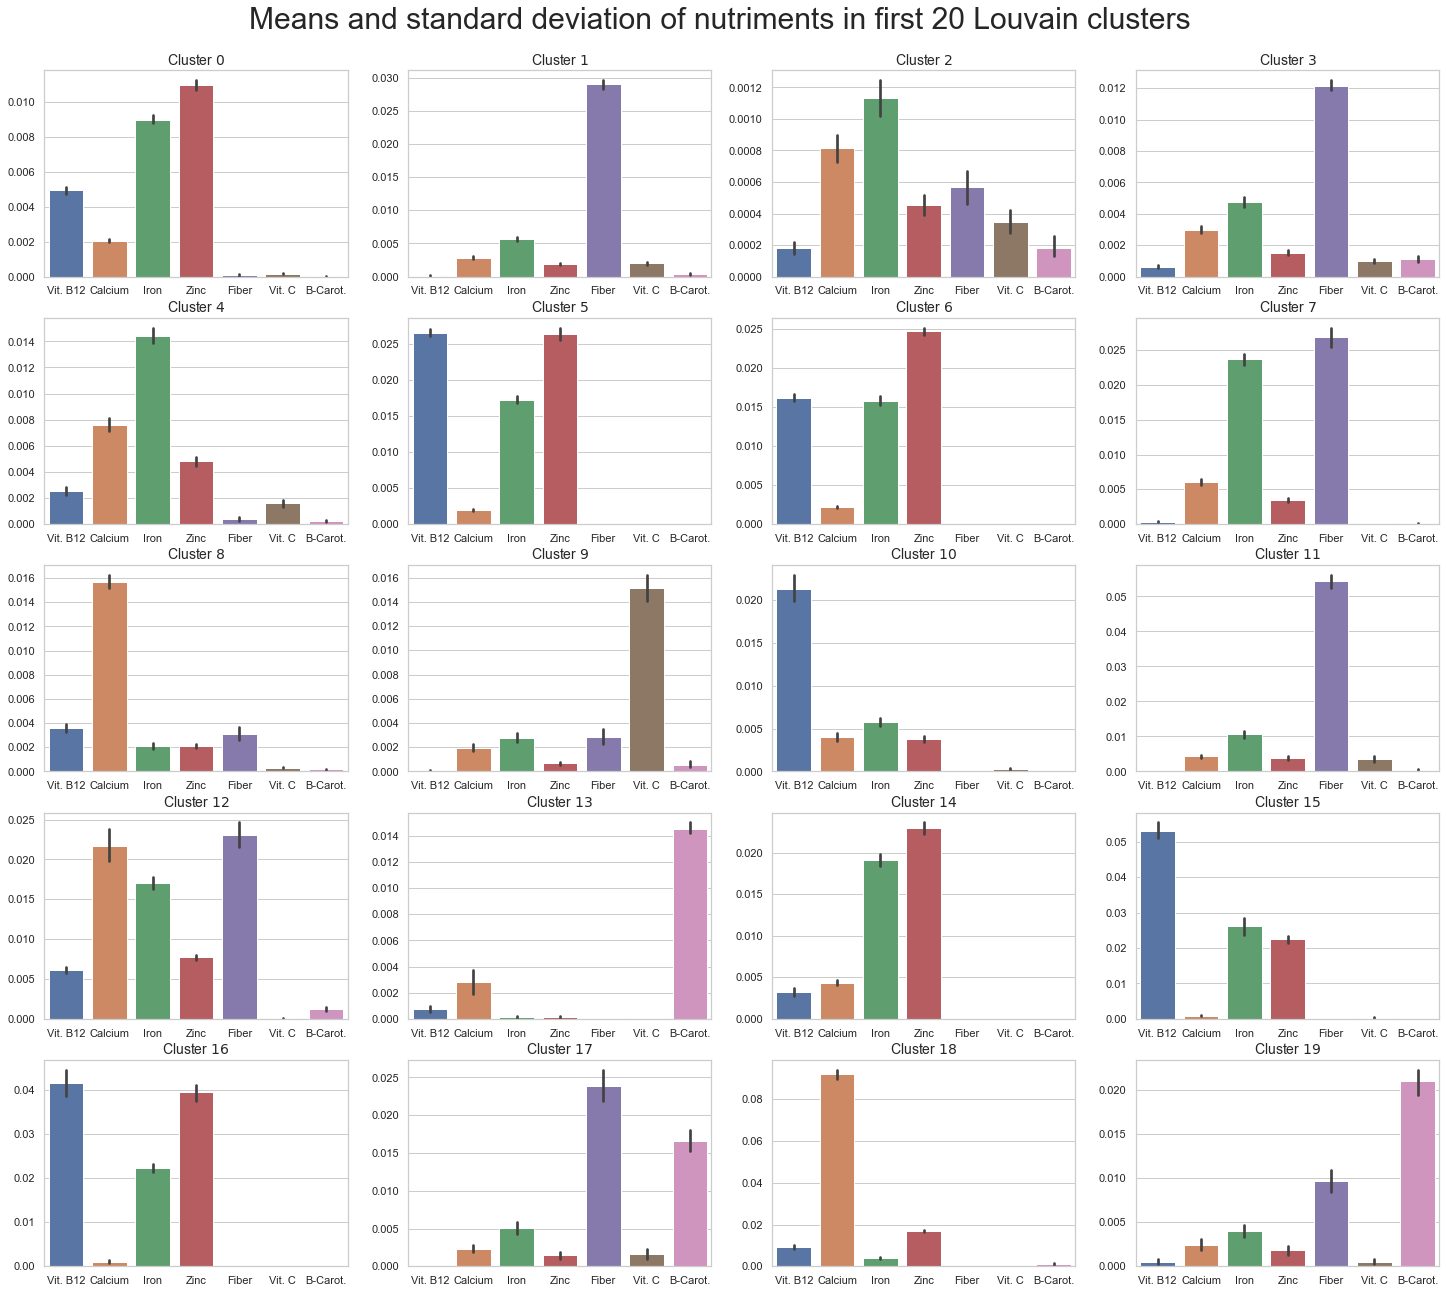

In [21]:
f,axs=plt.subplots(5,4,figsize=(25,22))
for i in range(len(axs)*len(axs[0])):
    unstacked = dataset.node_feature.iloc[indexes[i]].unstack().to_frame()
    sns.barplot(x=unstacked.index.get_level_values(0),y=unstacked[0], ax=axs[i//len(axs[0])][i%len(axs[0])])
    axs[i//len(axs[0])][i%len(axs[0])].yaxis.label.set_visible(False)
    axs[i//len(axs[0])][i%len(axs[0])].set_title(rf"Cluster ${i}$", fontsize =14)

plt.suptitle("Means and standard deviation of nutriments in first 20 Louvain clusters", fontsize =30, y=0.92)   
plt.show()

As per our initial hypotheses, we can identify vegetable in the first 20 clusters made by the Louvain algorithm by their fiber, vitamin C and beta-caroten content compared to the other four nutrients. We will therefore focus only on nutrient distribution, and mostly ignore their absolute value.

With those criteria, we identify clusters 2, 3, 7, 12 as being the most promising candidates. 

In [22]:
# Print 10 random elements from each interesting cluster to get an idea of the foods in them
rand_indexes = []
for i in [2,3,7,12]:
    rand_indexes.append(np.random.choice(indexes[i],10))

for idx, i in zip(rand_indexes, [2,3,7,12]):
    print("Cluster", i, dataset.description[idx].unique())

Cluster 2 ['CANDIES,TWIZZLERS CHERRY BITES' 'OIL,VEG,COCOA BUTTER'
 'PUDDING,LEMON,DRY MIX,REG,PREP W/ SUGAR,EGG YOLK & H2O'
 "CANDIES,NESTLE,BIT-O'-HONEY CANDY CHEWS"
 "CAMPBELL SOUP COMPANY,CAMPBELL'S MUSHROOM GRAVY"
 'CAMPBELL, SEL SOUP,HARVEST TOMATO W/ BASIL SOUP'
 'AGUTUK,FISH W/ SHORTENING (ALASKA NATIVE)'
 "CAMPBELL SOUP COMPANY,CAMPBELL'S SOUP AT HAND,VEG BF SOUP"
 'FROZEN NOVELTIES,ICE TYPE,POP'
 'OIL,VEG,INDUSTRIAL,SOY,REFINED,FOR WOKS & LT FRYING']
Cluster 3 ['POPEYES,FRIED CHICK,SPICY,BREAST,MEAT & SKN W/ BREADING'
 'BABYFOOD,FRUIT,BANANAS W/APPLS&PEARS,STR'
 "CAMPBELL'S SEL SOUP,NEW ENGLAND CLAM CHOWDER"
 'CELERY,CKD,BLD,DRND,WO/SALT' 'CAKE,WHITE,DRY MIX,PUDDING-TYPE,UNENR'
 'TOMATOES,YELLOW,RAW' 'BABYFOOD,DINNER,MACARONI&CHS,STR'
 'PEAR NECTAR,CND,WO/ VIT C' 'COCOA MIX,PDR,PREP W/ H2O'
 'BABYFOOD,BANANA APPL DSSRT,STR']
Cluster 7 ['BREAD,WHITE,PREP FROM RECIPE,MADE W/NONFAT DRY MILK'
 'GRANOLA BARS,SOFT,UNCOATED,CHOC CHIP,GRAHAM&MARSHMLLW'
 'CEREALS,QUAKER,INST OATMEAL,R

The clusters we get contain some varied foods but have a general theme.

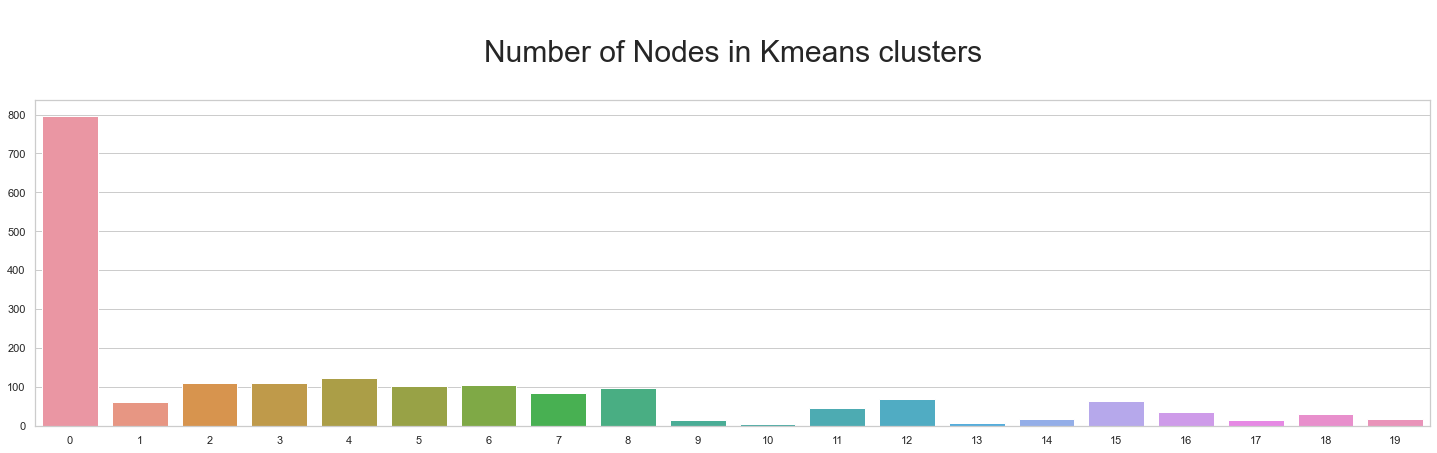

In [23]:
indexes = []
for i in range(len(np.unique(kmeansLabels))):
    indexes.append(np.where(kmeansLabels==i)[0])
categories = dataset.category.to_numpy()
categories_in_clusters = []
for index in indexes:
    temp = set()
    for i in index:
        temp.add(categories[i])
    categories_in_clusters.append(temp)

plt.figure(figsize=(25,6))
sns.set_theme(style="whitegrid")
sns.barplot(y=[len(cat) for cat  in categories_in_clusters],x=np.arange(len(categories_in_clusters)))
plt.title("\nNumber of Nodes in Kmeans clusters", fontsize = 30,y=1.1)
plt.show()

Contrary to what we got with Louvain, we can see here that Kmeans puts a large majority of foods in cluster 0. Printing the food categories of cluster 0, we get a little bit of everything, indicating that it was a "default cluster". 

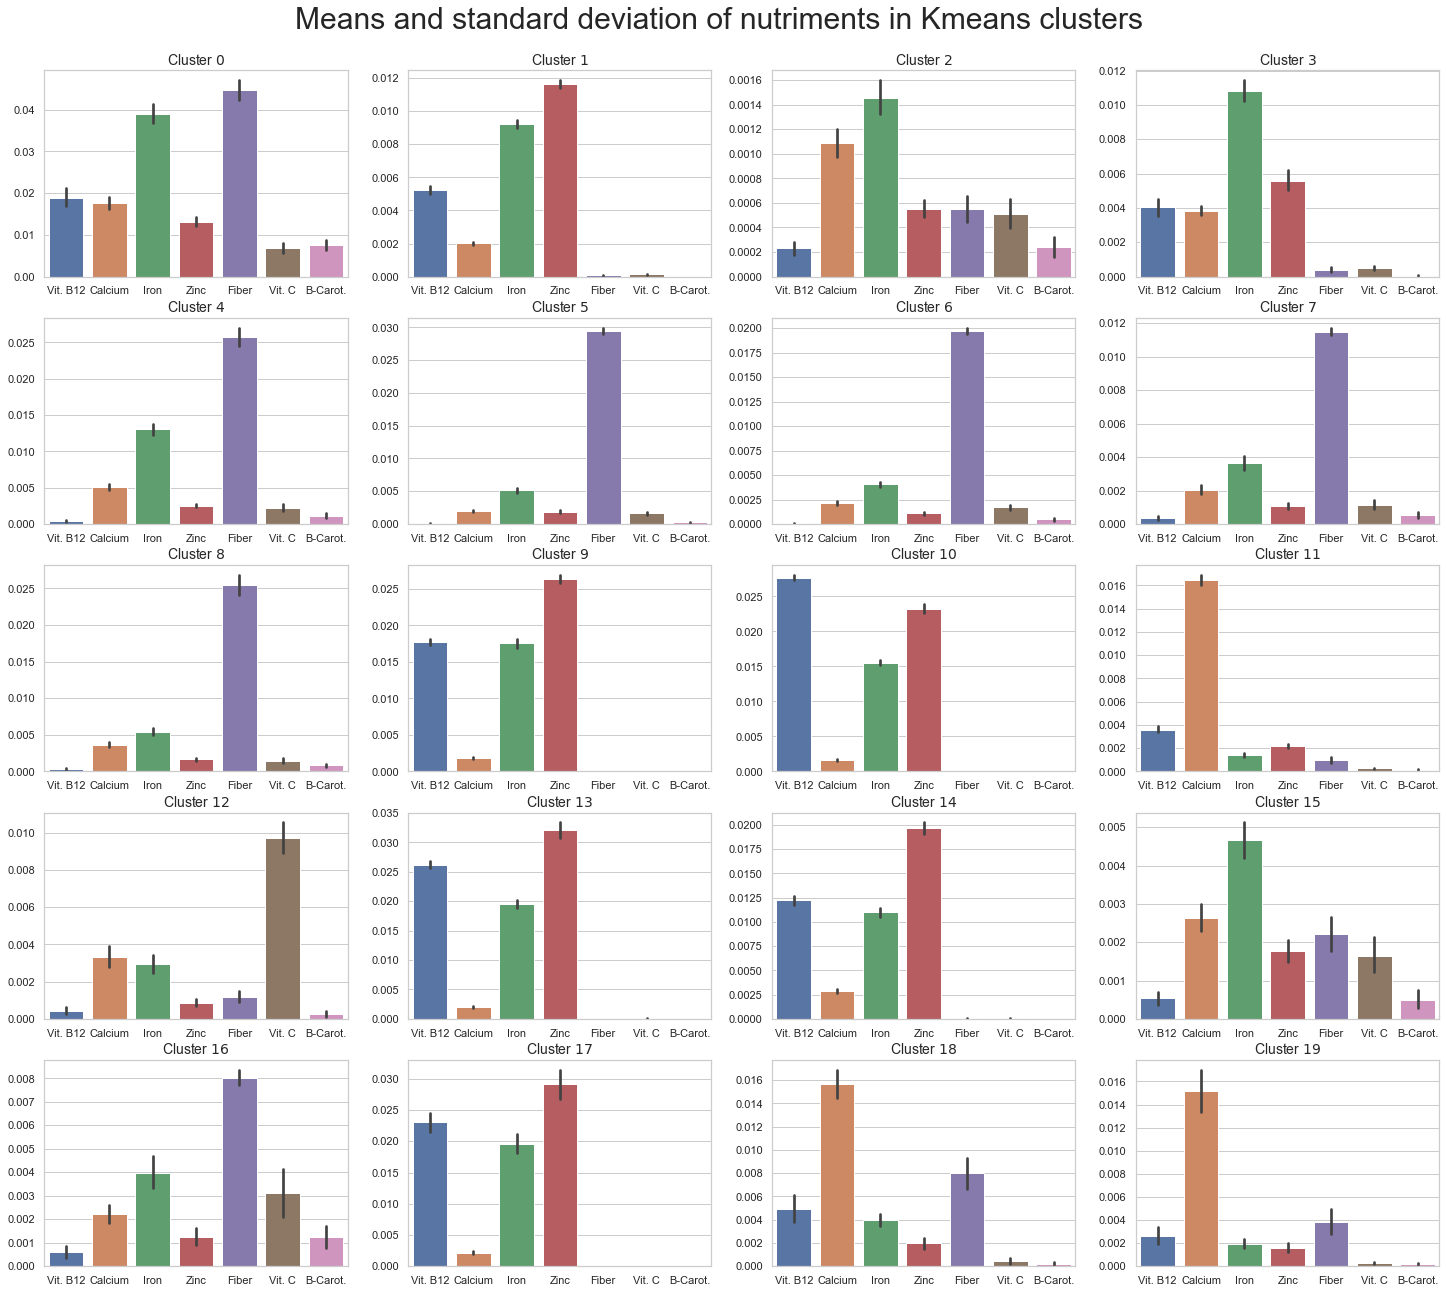

In [24]:
f,axs=plt.subplots(5,4,figsize=(25,22))
for i in range(len(axs)*len(axs[0])):
    unstacked = dataset.node_feature.iloc[indexes[i]].unstack().to_frame()
    sns.barplot(x=unstacked.index.get_level_values(0),y=unstacked[0], ax=axs[i//len(axs[0])][i%len(axs[0])])
    axs[i//len(axs[0])][i%len(axs[0])].yaxis.label.set_visible(False)
    axs[i//len(axs[0])][i%len(axs[0])].set_title(rf"Cluster ${i}$", fontsize =14)

plt.suptitle("Means and standard deviation of nutriments in Kmeans clusters", fontsize =30, y=0.92)   
plt.show()

With the above criteria, we identify clusters 2, 4, 15, 16  as being the most promising candidates. 

In [25]:
# Print 10 random elements from each interesting cluster to get an idea of the foods in them
rand_indexes = []
for i in [2,4,15,16]:
    rand_indexes.append(np.random.choice(indexes[i],10))

for idx, i in zip(rand_indexes, [2,4,15,16]):
    print("Cluster", i, dataset.description[idx].unique())

Cluster 2 ['CARBONATED BEV,LEMON-LIME SODA,CONTAINS CAFFEINE'
 'SPORTS DRK,FRUIT-FLAVORED,LO CAL,RTD' 'ALCOHOLIC BEV,DAIQUIRI,CND'
 'SEA BASS,MXD SP,CKD,DRY HEAT' 'CARBONATED BEV,GRAPE SODA'
 'BEEF BROTH&TOMATO JUC,CND' 'LEMONADE,PDR,PREP W/H2O' 'SUGARS,GRANULATED'
 "MCDONALD'S,CREAMY RANCH SAU" 'ANIMAL FAT,BACON GREASE']
Cluster 4 ['HORMEL CHILI W/BNS,CND ENTREE' 'CORN-BASED,EXTRUDED,CONES,PLN'
 "MCDONALD'S,BISCUIT,REG SIZE"
 'ARCHWAY Home Style Cookies, Date Filled Oatmeal'
 'GRAPEFRUIT,RAW,PINK & RED,FLORIDA' 'CROISSANTS,CHEESE'
 'SOUP,CHICK CORN CHOWDER,CHUNKY,RTS,SINGLE BRAND'
 'CABBAGE,RED,CKD,BLD,DRND,WO/SALT' 'BABYFOOD,FRUIT,APPL & RASPBERRY,STR'
 'CAKE,WHITE,DRY MIX,PUDDING-TYPE,ENR']
Cluster 15 ['CORN BEVERAGE' 'BUTTER,LT,STK,WO/SALT'
 'MACARONI,PROTEIN-FORTIFIED,CKD,ENR,(N X 5.70)'
 'HYACINTH-BEANS,IMMAT SEEDS,CKD,BLD,DRND,W/SALT'
 'SOUP,CRM OF CHICK,CND,COND' 'PIE,LEMON MERINGUE,PREP FROM RECIPE'
 "CAMPBELL'S RED & WHITE - MCRWVEABLE BOWLS,CHICK NOODLE SOUP"
 'SOUP,CRM OF O

Again, the clusters we get contain some varied foods but we can make out their general theme.